# Task
improve the model's performance using early stopping and potentially a transformer architecture, provide all possible model evaluation metrics, and include visualizations of the dataset and images.

Found 3236 images belonging to 2 classes.
Found 808 images belonging to 2 classes.
Training the model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8019 - loss: 0.6655

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 555s 5s/step - accuracy: 0.8023 - loss: 0.6632 - val_accuracy: 0.8540 - val_loss: 0.3819
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.8861 - loss: 0.2721 - val_accuracy: 0.8527 - val_loss: 0.3371
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.9346 - loss: 0.1785 - val_accuracy: 0.7995 - val_loss: 0.4868
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step - accuracy: 0.9502 - loss: 0.1395 - val_accuracy: 0.7067 - val_loss: 0.7037
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.9338 - loss: 0.1583 - val_accuracy: 0.7772 - val_loss: 0.5187
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.9577 - loss: 0.1193 - val_accuracy: 0.8106 - val_loss: 0.5018
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9625 - loss: 0.1028 - val_accuracy: 0.8069 - val_loss: 0.5034

Fine-tuning the model...
Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 306s 3s/step - accuracy: 0.8612 - loss: 0.

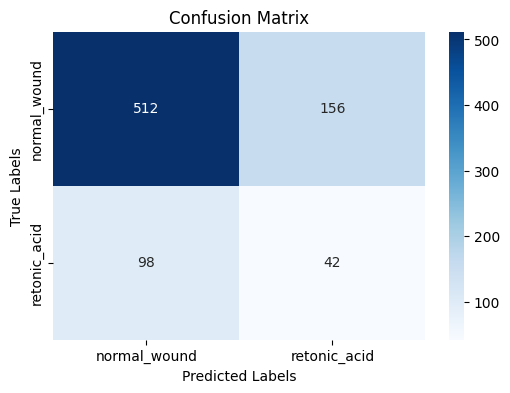


Classification Report:
              precision    recall  f1-score   support

normal_wound       0.84      0.77      0.80       668
retonic_acid       0.21      0.30      0.25       140

    accuracy                           0.69       808
   macro avg       0.53      0.53      0.52       808
weighted avg       0.73      0.69      0.71       808


ROC Curve and AUC:


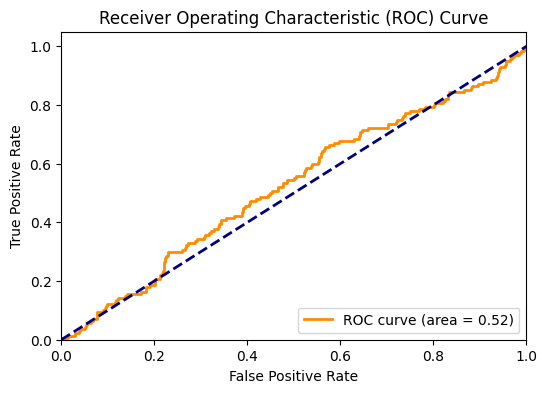

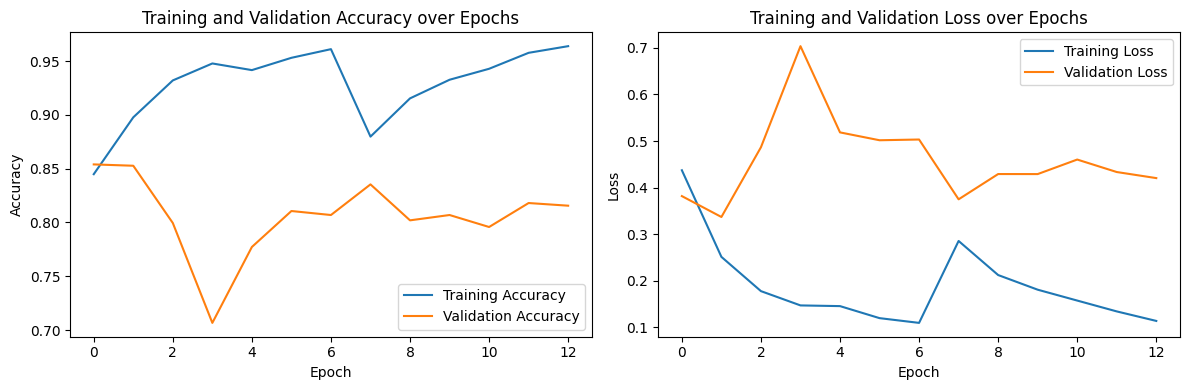

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    validation_split=0.2 # 80% train, 20% validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Augmented_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Augmented_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Model Definition (Transfer Learning with MobileNetV2)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False # Freeze the base model initially

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax') # Output layer with number of classes
])

# Model Compilation
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Model Training (Phase 1)
print("Training the model...")
history = model.fit(
    train_generator,
    epochs=20, # You can set a sufficiently large number of epochs, early stopping will stop it
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

# Fine-tuning the model (Optional but Recommended)
print("\nFine-tuning the model...")
base_model.trainable = True # Unfreeze the base model

# Fine-tune only the last few layers
for layer in base_model.layers[:-30]:  # Freeze all layers except last 30
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Smaller LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Set callbacks again for fine-tuning
early_stop_fine = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_fine = ModelCheckpoint('best_model_finetuned.keras', monitor='val_accuracy', save_best_only=True)

history_fine = model.fit(
    train_generator,
    epochs=20,  # Fine-tuning can be for fewer epochs
    validation_data=val_generator,
    callbacks=[early_stop_fine, checkpoint_fine]
)

# Evaluate the model
print("\nEvaluating the model...")
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss after fine-tuning: {val_loss:.4f}")
print(f"Validation Accuracy after fine-tuning: {val_accuracy:.4f}")

# Get predictions for evaluation metrics
val_generator.reset() # Reset generator to ensure correct order
predictions = model.predict(val_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

# ROC Curve and AUC (for binary classification)
if len(class_labels) == 2:
    print("\nROC Curve and AUC:")
    # Assuming the positive class is the second class in class_labels
    fpr, tpr, _ = roc_curve(true_labels, predictions[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("\nROC Curve and AUC are typically calculated for binary classification.")


# Plot Training and Validation Accuracy over Epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss over Epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step

Prediction for image: /content/drive/MyDrive/Augmented_dataset/retonic_acid/10dRA/aug_0_1071.jpg
Predicted Class: retonic_acid
Probabilities per class:
  normal_wound: 0.1216
  retonic_acid: 0.8784


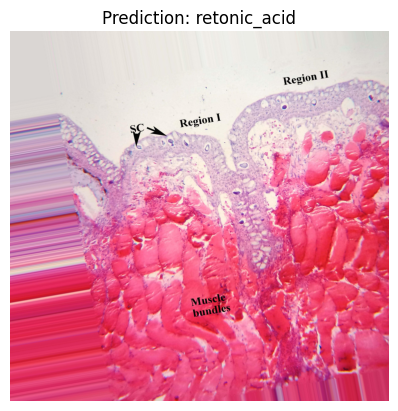

In [5]:
# To make a prediction on a new image, you can use the loaded model.
# First, load the trained model (the one saved as 'best_model_finetuned.keras')
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the best trained model
# model = load_model('best_model_finetuned.keras')

# Assuming 'class_labels' is already defined from the evaluation part
# class_labels = list(val_generator.class_indices.keys())

def predict_image(image_path, model, class_labels):
  """
  Loads an image, preprocesses it, and makes a prediction using the trained model.

  Args:
    image_path (str): Path to the image file.
    model: The trained Keras model.
    class_labels (list): A list of class names in the correct order.

  Returns:
    tuple: A tuple containing the predicted class label and the prediction probabilities.
  """
  img = image.load_img(image_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
  img_array /= 255.0 # Rescale the image

  predictions = model.predict(img_array)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_label = class_labels[predicted_class_index]
  probabilities = predictions[0]

  return predicted_label, probabilities

# Example usage:
# Replace '/content/drive/MyDrive/path/to/your/test_image.jpg' with the actual path to your image
test_image_path = '/content/drive/MyDrive/Augmented_dataset/retonic_acid/10dRA/aug_0_1071.jpg' # **Modify this line**

# Make a prediction on the test image
predicted_label, probabilities = predict_image(test_image_path, model, class_labels)

print(f"\nPrediction for image: {test_image_path}")
print(f"Predicted Class: {predicted_label}")
print("Probabilities per class:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {probabilities[i]:.4f}")

# Optional: Display the image with the prediction
img = image.load_img(test_image_path)
plt.imshow(img)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()

Showing 5 random images with their True and Predicted Classes:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


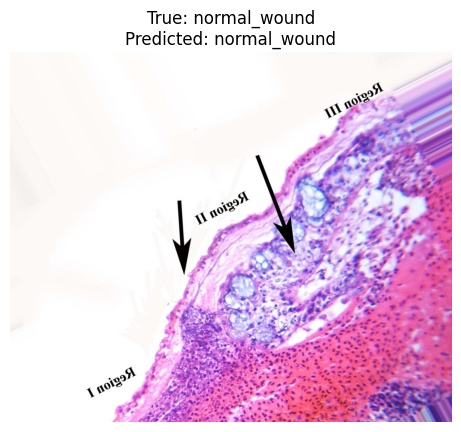

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


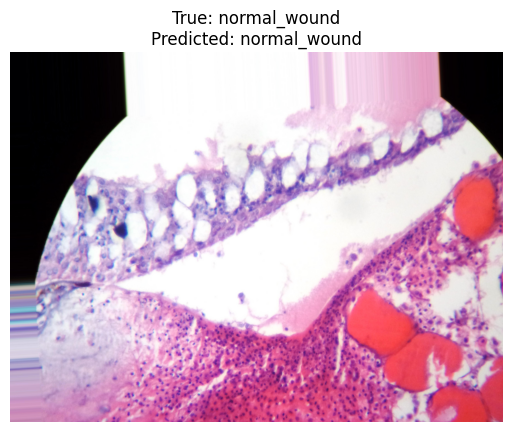

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


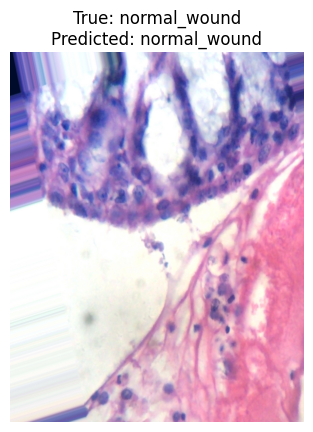

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


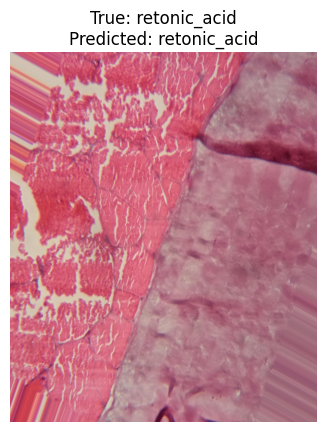

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


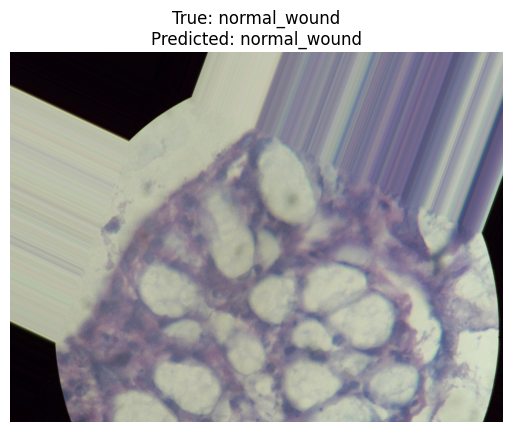

In [13]:
# prompt: Just  like above code, take 5 random images from the dataset link and show true and predicted class , example of my image link /content/drive/MyDrive/Augmented_dataset/retonic_acid/10dRA/aug_0_1071.jpg and /content/drive/MyDrive/Augmented_dataset/normal_wound/10dayspw/aug_0_1214.jpg so for this and true class should be between normal_wound or retonic_acid not the timestap folder class

import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Assuming 'model' and 'class_labels' are already defined and the model is trained/loaded

def predict_image_and_display(image_path, model, class_labels):
  """
  Loads an image, preprocesses it, makes a prediction, determines the true class,
  and displays the image with predicted and true classes.

  Args:
    image_path (str): Path to the image file.
    model: The trained Keras model.
    class_labels (list): A list of class names in the correct order.
  """
  # Determine the true class from the directory structure
  # The true class is the folder name immediately after '/Augmented_dataset/'
  parts = image_path.split(os.sep)
  try:
      augmented_dataset_index = parts.index('Augmented_dataset')
      # Find the first relevant class name after the dataset root
      # We look for 'normal_wound' or 'retonic_acid'
      true_class = None
      for part in parts[augmented_dataset_index + 1:]:
          if part in ['normal_wound', 'retonic_acid']:
              true_class = part
              break
  except ValueError:
      true_class = "Unknown" # Should not happen with given paths

  if true_class is None:
      true_class = "Unknown" # Handle cases where the desired class is not found

  # Make the prediction
  predicted_label, probabilities = predict_image(image_path, model, class_labels)

  # Display the image and results
  img = image.load_img(image_path)
  plt.imshow(img)
  plt.title(f"True: {true_class}\nPredicted: {predicted_label}")
  plt.axis('off')
  plt.show()

# Get all image paths from the dataset directory
dataset_dir = '/content/drive/MyDrive/Augmented_dataset'
all_image_paths = []
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(root, file))

# Select 5 random image paths
random_image_paths = random.sample(all_image_paths, 5)

# Process and display predictions for the random images
print("Showing 5 random images with their True and Predicted Classes:")
for img_path in random_image_paths:
    predict_image_and_display(img_path, model, class_labels)


Showing 5 random images with their True and Predicted Classes and Confidence:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


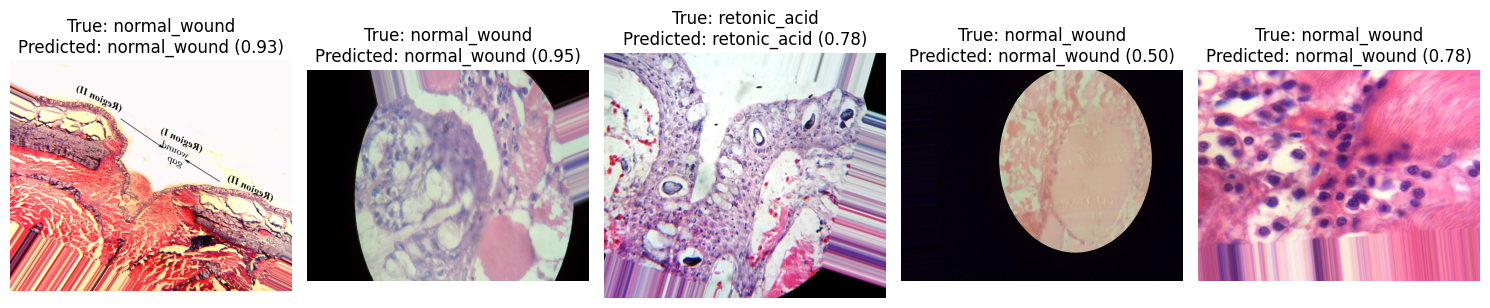

In [14]:
# prompt: do the same thing you did in the above code just add confidence and show images horizonatlly

def predict_image_and_display_with_confidence_horizontal(image_path, model, class_labels):
  """
  Loads an image, preprocesses it, makes a prediction, determines the true class,
  and displays the image with predicted and true classes and confidence score.
  Displays images horizontally.

  Args:
    image_path (str): Path to the image file.
    model: The trained Keras model.
    class_labels (list): A list of class names in the correct order.
  """
  # Determine the true class from the directory structure
  parts = image_path.split(os.sep)
  try:
      augmented_dataset_index = parts.index('Augmented_dataset')
      true_class = None
      for part in parts[augmented_dataset_index + 1:]:
          if part in ['normal_wound', 'retonic_acid']:
              true_class = part
              break
  except ValueError:
      true_class = "Unknown"

  if true_class is None:
      true_class = "Unknown"

  # Make the prediction
  predicted_label, probabilities = predict_image(image_path, model, class_labels)

  # Get the confidence score for the predicted class
  predicted_class_index = class_labels.index(predicted_label)
  confidence = probabilities[predicted_class_index]

  # Display the image and results
  img = image.load_img(image_path)
  plt.imshow(img)
  plt.title(f"True: {true_class}\nPredicted: {predicted_label} ({confidence:.2f})")
  plt.axis('off')


# Select 5 random image paths
random_image_paths = random.sample(all_image_paths, 5)

# Create a figure to display images horizontally
plt.figure(figsize=(15, 5))

# Process and display predictions for the random images horizontally
print("Showing 5 random images with their True and Predicted Classes and Confidence:")
for i, img_path in enumerate(random_image_paths):
    plt.subplot(1, 5, i + 1) # 1 row, 5 columns, current image index
    predict_image_and_display_with_confidence_horizontal(img_path, model, class_labels)

plt.tight_layout()
plt.show()
